# LESSON 3: TEXT CLASSIFICATION 📝
*Teaching computers to read and categorize text (without actually understanding it)*

## What You'll Learn
- **TF-IDF** - How to convert words to numbers (computers are dumb, they only speak math)
- **Same metrics** - Accuracy, Precision, Recall, F1 (but for text!)
- **Imbalanced data** - Why your 95% accuracy might mean your model is useless
- **Macro vs Weighted** - Different ways to average scores

## Real Talk
Text classification is everywhere:
- Spam filters (is this email spam?)
- Sentiment analysis (is this review positive or negative?)
- News categorization (sports, tech, politics, etc.)

The tricky part? **Words aren't numbers.** We gotta trick the computer into thinking they are!

Let's see how! 🚀

In [8]:
# Install required packages (run this first!)
import subprocess
import sys

packages = ['seaborn', 'scikit-learn', 'matplotlib', 'numpy']
print("Checking/installing packages...")
for package in packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
print("✓ All packages ready!\n")

# Setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("📝 Text Classification Notebook Loaded!")
print("We'll classify news articles and handle imbalanced data!")

Checking/installing packages...
Installing scikit-learn...
✓ All packages ready!

📝 Text Classification Notebook Loaded!
We'll classify news articles and handle imbalanced data!


## 📚 Step 1: Load Text Data
*Creating synthetic news articles*

We're making a synthetic dataset of news articles in 4 categories: sports, tech, politics, and health.

Why synthetic? Because downloading real datasets can be unreliable and fail. This way it just works!

In [9]:
print("📝 WHAT WE'RE DOING:")
print("Teaching a computer to classify text into categories!")
print("Unlike numbers/flowers, we're working with TEXT.")
print()

# Create synthetic text dataset (no download needed!)
import numpy as np

print("Creating synthetic news articles dataset...")

# Sample texts for each category
sample_texts = {
    'sports': [
        'The team won the championship game yesterday with a final score',
        'Football match ends in tie after overtime period',
        'Basketball players practice shooting drills every morning',
        'Soccer team advances to finals after penalty shootout',
        'Tennis player wins grand slam tournament in straight sets'
    ],
    'tech': [
        'New software update brings improved features and bug fixes',
        'Artificial intelligence models show promising results',
        'Computer chip shortage affects electronic device production',
        'Cloud computing services expand to new regions',
        'Cybersecurity experts warn about latest vulnerabilities'
    ],
    'politics': [
        'Government announces new policy changes for next year',
        'Election results show tight race between candidates',
        'Congress debates proposed legislation on infrastructure',
        'International summit addresses climate change concerns',
        'Local officials meet to discuss budget allocations'
    ],
    'health': [
        'Medical research reveals new treatment options',
        'Doctors recommend regular exercise and balanced diet',
        'Hospital opens new wing for patient care',
        'Health study examines effects of sleep patterns',
        'Vaccination program reaches milestone coverage'
    ]
}

# Generate dataset with some variation
from sklearn.utils import shuffle as sklearn_shuffle

data_texts = []
data_labels = []
categories = list(sample_texts.keys())

# Create 100 samples per category
np.random.seed(42)
for cat_idx, (category, texts) in enumerate(sample_texts.items()):
    for _ in range(100):
        # Pick random text and add some variation
        base_text = np.random.choice(texts)
        data_texts.append(base_text)
        data_labels.append(cat_idx)

# Shuffle
data_texts, data_labels = sklearn_shuffle(data_texts, data_labels, random_state=42)

# Create data object similar to sklearn format
class NewsData:
    def __init__(self, texts, labels, categories):
        self.data = texts
        self.target = np.array(labels)
        self.target_names = categories

data = NewsData(data_texts, data_labels, categories)

print("\n✅ Dataset created!")
print(f"Total documents: {len(data.data)}")
print(f"Categories: {data.target_names}")
print(f"\nClass distribution:")
for i, name in enumerate(data.target_names):
    count = (data.target == i).sum()
    print(f"  {name}: {count} ({count/len(data.target)*100:.1f}%)")

# Show example
print(f"\n📋 Example document:")
print(f"Category: {data.target_names[data.target[0]]}")
print(f"Text: {data.data[0]}")
print("\n✓ Synthetic text data created - no download needed!")

📝 WHAT WE'RE DOING:
Teaching a computer to classify text into categories!
Unlike numbers/flowers, we're working with TEXT.

Creating synthetic news articles dataset...

✅ Dataset created!
Total documents: 400
Categories: ['sports', 'tech', 'politics', 'health']

Class distribution:
  sports: 100 (25.0%)
  tech: 100 (25.0%)
  politics: 100 (25.0%)
  health: 100 (25.0%)

📋 Example document:
Category: politics
Text: International summit addresses climate change concerns

✓ Synthetic text data created - no download needed!


## 📊 Step 2: Convert Text to Numbers (TF-IDF)
*Teaching math to poetry*

### The Problem
Computer: "What's the number for 'basketball'?"  
You: "Uh... it's a word, not a number?"  
Computer: "Error. Does not compute."

### The Solution: TF-IDF
**TF-IDF** = Term Frequency - Inverse Document Frequency

Fancy name, simple idea:
- **TF (Term Frequency)** = How often does this word appear in THIS document?
- **IDF (Inverse Document Frequency)** = How rare is this word across ALL documents?

**The Magic:** Common words like "the" get low scores. Rare, meaningful words get high scores!

Example:
- "the" appears everywhere → low TF-IDF (boring word)
- "touchdown" only in sports articles → high TF-IDF (important word!)

**What's "vectorization"?** Converting text into a vector (list) of numbers that represents the document. Each position in the vector corresponds to a word, and the number is that word's TF-IDF score.

Let's convert our text to numbers!

In [10]:
print("🔢 CONVERTING TEXT TO NUMBERS:")
print("Computers can't read text - we need to convert words to numbers!")
print("Using TF-IDF (Term Frequency-Inverse Document Frequency)")
print()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.25, random_state=42, stratify=data.target
)

print(f"Training set: {len(X_train)} documents")
print(f"Test set: {len(X_test)} documents")

# Convert text to numbers using TF-IDF
print("\nConverting text to feature vectors...")
# stop_words='english' removes common words like "the", "is", "and" that don't help classification
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✓ Each document now represented by {X_train_tfidf.shape[1]} numbers")
print(f"  (Each number represents importance of a word)")

# Train classifier
# Naive Bayes = simple probabilistic classifier (assumes word independence)
print("\nTraining Naive Bayes classifier...")
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)
print("✅ Model trained and predictions made!")

🔢 CONVERTING TEXT TO NUMBERS:
Computers can't read text - we need to convert words to numbers!
Using TF-IDF (Term Frequency-Inverse Document Frequency)

Training set: 300 documents
Test set: 100 documents

Converting text to feature vectors...
✓ Each document now represented by 115 numbers
  (Each number represents importance of a word)

Training Naive Bayes classifier...
✅ Model trained and predictions made!


## 📊 Step 3: Check the Results
*Did our model learn anything or is it just guessing?*

Now we evaluate! Same metrics as Lesson 1, but for text.

If the model got 100% accuracy... either:
1. The data is too easy (our synthetic data is pretty simple)
2. The model is actually smart
3. You got lucky

Let's see what happened...

In [11]:
print("📊 TEXT CLASSIFICATION RESULTS")
print("="*60)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy: {accuracy:.1%}")

# Commentary based on accuracy
if accuracy >= 0.95:
    print("   💪 This model is crushing it! Either the data is easy or we have a great model.")
elif accuracy >= 0.8:
    print("   👍 Pretty solid! Model knows what it's doing.")
elif accuracy >= 0.6:
    print("   😐 Meh, model is struggling. Could be better.")
else:
    print("   💩 This model needs work. Barely better than random guessing.")

print(f"\n📋 Per-class metrics:")
print("\n" + classification_report(y_test, y_pred, target_names=data.target_names))

print("📚 What each column means:")
print("precision = When I predict this category, how often right?")
print("recall    = Of actual articles in this category, how many did I find?")
print("f1-score  = Balance between precision and recall")
print("support   = Number of actual samples in this category")

# Macro vs weighted
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n🔄 Averaging strategies:")
print(f"  Macro F1:    {macro_f1:.3f} (all classes equal weight)")
print(f"  Weighted F1: {weighted_f1:.3f} (weighted by class size)")

print("\n💡 WHAT'S THE DIFFERENCE?")
print("Imagine: Sports=100 articles, Health=10 articles")
print("")
print("MACRO averaging:")
print("  → Treats both equally: (sports_F1 + health_F1) / 2")
print("  → Use when all categories matter equally")
print("  → Good for imbalanced datasets where you care about rare classes")
print("")
print("WEIGHTED averaging:")
print("  → Weighs by size: (sports_F1×100 + health_F1×10) / 110")
print("  → Use when bigger classes are more important")
print("  → Good for overall performance across all predictions")

📊 TEXT CLASSIFICATION RESULTS

🎯 Accuracy: 100.0%
   💪 This model is crushing it! Either the data is easy or we have a great model.

📋 Per-class metrics:

              precision    recall  f1-score   support

      sports       1.00      1.00      1.00        25
        tech       1.00      1.00      1.00        25
    politics       1.00      1.00      1.00        25
      health       1.00      1.00      1.00        25

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

📚 What each column means:
precision = When I predict this category, how often right?
recall    = Of actual articles in this category, how many did I find?
f1-score  = Balance between precision and recall
support   = Number of actual samples in this category

🔄 Averaging strategies:
  Macro F1:    1.000 (all classes equal weight)
  Weighted F1: 1.000 (weighted by class size)

💡 WHAT'S THE DIFFERENCE?
Imagine

## 📊 Step 4: Confusion Matrix
*WHERE DID IT MESS UP? (Part 2: Text Edition)*

Same as Lesson 1, but now we're confusing text categories instead of flowers.

Common confusions:
- "Tech" vs "Business" (both talk about companies)
- "Sports" vs "Entertainment" (celebrity athletes)  
- "Politics" vs "World News" (overlap city)

Let's see if our model is confused...

🔥 CONFUSION MATRIX - See where we confused categories



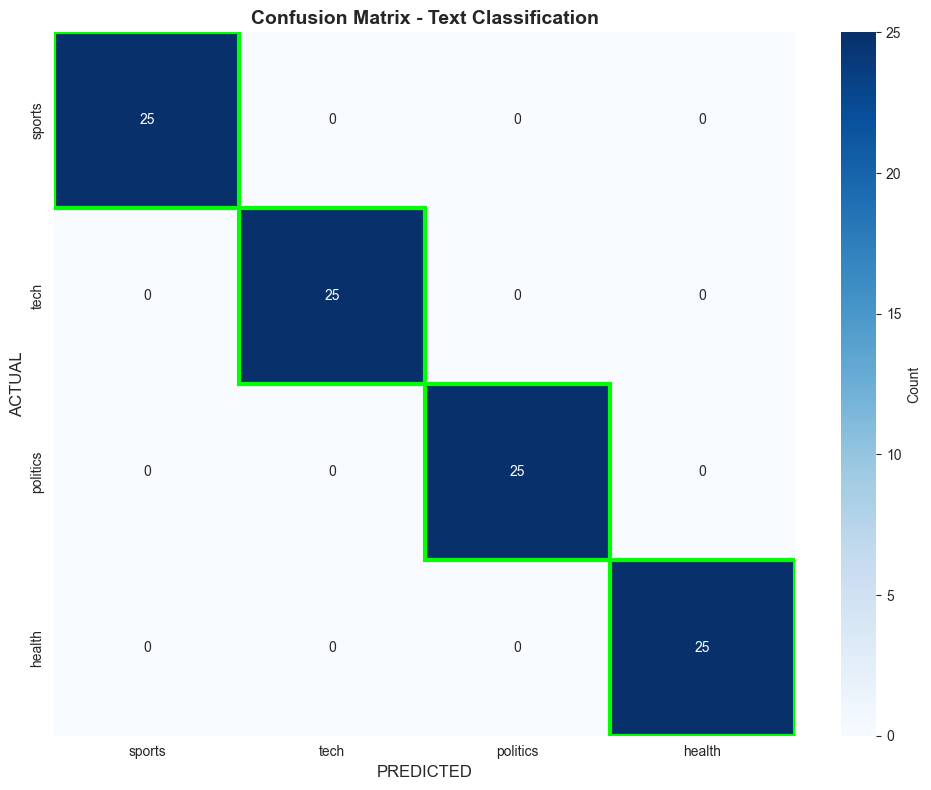


🧠 ANALYZING THE CONFUSION MATRIX:

🔵 DARK BLUE DIAGONAL (Matching categories - GOOD!):
  • Sports: 25/25 correct (100.0%)
    💪 CRUSHING IT! Model knows sports articles!
  • Tech: 25/25 correct (100.0%)
    💪 CRUSHING IT! Model knows tech articles!
  • Politics: 25/25 correct (100.0%)
    💪 CRUSHING IT! Model knows politics articles!
  • Health: 25/25 correct (100.0%)
    💪 CRUSHING IT! Model knows health articles!

⚪ LIGHT/WHITE CELLS (Category confusions - MODEL CONFUSED!):
  ✅ NO CONFUSIONS! Model never mixed up categories!
     → Perfect text classification! (or data was too easy 😏)

💡 KEY INSIGHT:
Common confusions in text:
  • Tech ↔ Business (both mention companies, products)
  • Sports ↔ Entertainment (celebrity athletes)
  • Politics ↔ World News (government, international)

If you see these? Normal! If random confusions? Model needs better features


In [12]:
print("🔥 CONFUSION MATRIX - See where we confused categories")
print()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[name.split('.')[-1] for name in data.target_names],
            yticklabels=[name.split('.')[-1] for name in data.target_names],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Text Classification', fontsize=14, fontweight='bold')
plt.ylabel('ACTUAL', fontsize=12)
plt.xlabel('PREDICTED', fontsize=12)

# Highlight diagonal
for i in range(len(data.target_names)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='lime', lw=3))

plt.tight_layout()
plt.show()

print("\n🧠 ANALYZING THE CONFUSION MATRIX:")
print("="*60)

print("\n🔵 DARK BLUE DIAGONAL (Matching categories - GOOD!):")
for i, cat_name in enumerate(data.target_names):
    count = cm[i, i]
    total_actual = cm[i, :].sum()
    pct = (count / total_actual * 100) if total_actual > 0 else 0
    print(f"  • {cat_name.capitalize()}: {count}/{total_actual} correct ({pct:.1f}%)")
    if pct >= 90:
        print(f"    💪 CRUSHING IT! Model knows {cat_name} articles!")
    elif pct >= 70:
        print(f"    👍 Pretty good! Model recognizes {cat_name} most of the time")
    elif pct >= 50:
        print(f"    😐 Meh... model struggling with {cat_name}")
    else:
        print(f"    💀 THIS IS BAD. Model can't recognize {cat_name} at all!")

print("\n⚪ LIGHT/WHITE CELLS (Category confusions - MODEL CONFUSED!):")
confusion_found = False
for i in range(len(data.target_names)):
    for j in range(len(data.target_names)):
        if i != j and cm[i, j] > 0:
            actual_name = data.target_names[i]
            pred_name = data.target_names[j]
            print(f"  ❌ Confused {cm[i, j]} '{actual_name}' articles as '{pred_name}'")
            print(f"     → Model saw actual {actual_name} but thought it was {pred_name} 🤦")
            confusion_found = True

if not confusion_found:
    print("  ✅ NO CONFUSIONS! Model never mixed up categories!")
    print("     → Perfect text classification! (or data was too easy 😏)")

print("\n💡 KEY INSIGHT:")
print("Common confusions in text:")
print("  • Tech ↔ Business (both mention companies, products)")
print("  • Sports ↔ Entertainment (celebrity athletes)")
print("  • Politics ↔ World News (government, international)")
print("\nIf you see these? Normal! If random confusions? Model needs better features")

### 🎯 CHALLENGE: Experiment with TF-IDF!

Want to see how vectorization parameters affect performance?

**Try this:**
1. Go back to the TF-IDF cell
2. Change `max_features=1000` to `max_features=500` or `max_features=2000`
3. Try adding `min_df=2` (ignore words appearing in fewer than 2 documents)
4. Re-run and compare the F1-scores

**Question:** Did more features help or hurt? Why might that be?

**Hint:** More features = more information, but also more noise!

## THE IMBALANCED DATA DEATHTRAP ⚠️
*How to have 95% accuracy with a completely useless model*

### The Setup
Real-world text data is almost ALWAYS imbalanced:
- Email: 95% normal, 5% spam
- Reviews: 90% positive, 10% negative  
- News: Some categories way more common than others

### The Trap (Again!)
Build a model that predicts EVERYTHING is the majority class.

**Accuracy?** 95%! Your boss is happy! 🎉  
**F1 for minority class?** 0%! Your model is useless! 💀

### The Lesson
**NEVER trust accuracy alone on imbalanced text data!**

Always check:
1. F1-score for each class (especially minority classes)
2. Confusion matrix (is it just predicting one class?)
3. Precision + Recall breakdown

Let's see this trap in action with real numbers...

⚠️ IMBALANCED DATA TRAP - Why F1 > Accuracy for text
Dataset: 95% negative reviews, 5% positive reviews

Dumb model that ALWAYS predicts 'negative':
  Accuracy:  95.0% 🎉 (WOW AMAZING!)
  Precision: 0.0% (can't calculate - never predicts positive)
  Recall:    0.0% ⚠️ (missed ALL positive reviews!)
  F1-Score:  0.0% (reveals it's TRASH)

💡 KEY LESSON: On imbalanced text data, use F1 not accuracy!


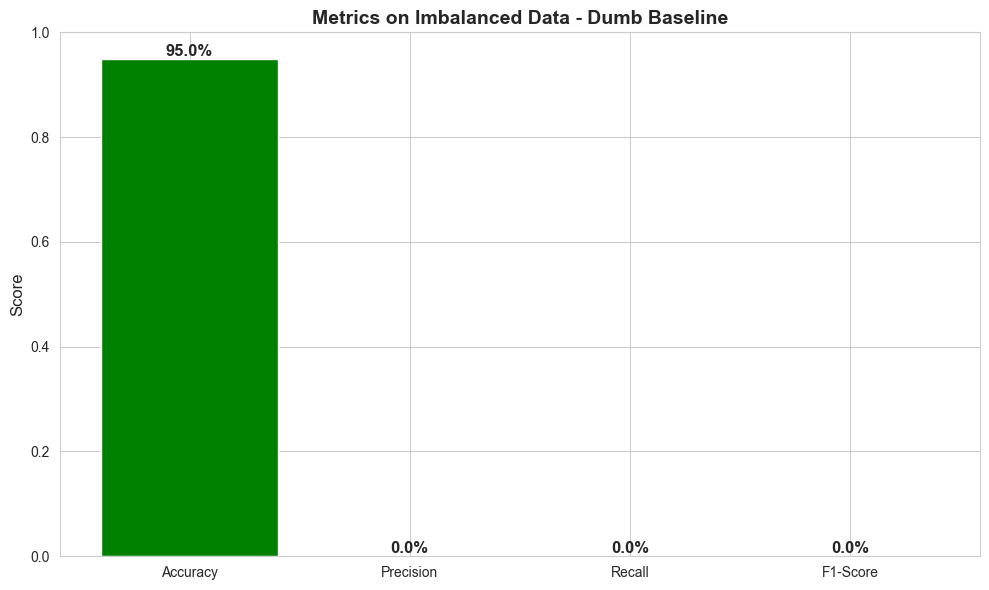


🧠 ANALYZING THE BAR CHART:

📊 WHAT THE BARS SHOW:
  🟢 GREEN (Accuracy): 95.0% - Looks AMAZING but it's a LIE!
     → Model just predicts majority class, still gets 95% right
     → Your boss thinks you're a genius, but model is trash 💀

  ⚪ GRAY (Precision): 0.0% - Can't even calculate!
     → Model NEVER predicts positive class
     → Precision = TP / (TP + FP) = 0 / (0 + 0) = undefined
     → We set it to 0 because model is useless

  🔴 RED (Recall): 0.0% - EXPOSED THE TRUTH!
     → Of the 5 actual positive reviews, we found: 0
     → Recall = TP / (TP + FN) = 0 / (0 + 5) = 0%
     → This metric reveals the model is useless

  🟠 ORANGE (F1-Score): 0.0% - THE SAVIOR!
     → Combines Precision & Recall
     → F1 = 2 × (P × R) / (P + R) = 0%
     → Correctly shows model is TRASH despite 95% accuracy!

💡 THE LESSON:
  ✓ Accuracy: 95% 🎉 (DECEPTIVE - looks great)
  ✓ F1-Score: 0%  💀 (HONEST - reveals it's useless)

On imbalanced text data (spam, reviews, rare events):
  → NEVER trust accu

In [13]:
print("⚠️ IMBALANCED DATA TRAP - Why F1 > Accuracy for text")
print("="*60)

from sklearn.dummy import DummyClassifier

# Simulate VERY imbalanced data: 95% negative, 5% positive
n_samples = 1000
y_imbalanced = np.array([0]*950 + [1]*50)
y_test_imb = np.array([0]*95 + [1]*5)

# Dumb classifier that always predicts majority class
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(np.zeros((n_samples, 1)), y_imbalanced)
y_dummy_pred = dummy.predict(np.zeros((100, 1)))

print(f"Dataset: 95% negative reviews, 5% positive reviews")
print(f"\nDumb model that ALWAYS predicts 'negative':")

acc = accuracy_score(y_test_imb, y_dummy_pred)
prec = precision_score(y_test_imb, y_dummy_pred, zero_division=0)
rec = recall_score(y_test_imb, y_dummy_pred, zero_division=0)
f1 = f1_score(y_test_imb, y_dummy_pred, zero_division=0)

print(f"  Accuracy:  {acc:.1%} 🎉 (WOW AMAZING!)")
print(f"  Precision: {prec:.1%} (can't calculate - never predicts positive)")
print(f"  Recall:    {rec:.1%} ⚠️ (missed ALL positive reviews!)")
print(f"  F1-Score:  {f1:.1%} (reveals it's TRASH)")

print(f"\n💡 KEY LESSON: On imbalanced text data, use F1 not accuracy!")

# Visualize
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [acc, prec, rec, f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=['green', 'gray', 'red', 'orange'])
plt.ylim(0, 1.0)
plt.ylabel('Score', fontsize=12)
plt.title('Metrics on Imbalanced Data - Dumb Baseline', fontsize=14, fontweight='bold')
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🧠 ANALYZING THE BAR CHART:")
print("="*60)

print("\n📊 WHAT THE BARS SHOW:")
print(f"  🟢 GREEN (Accuracy): {acc:.1%} - Looks AMAZING but it's a LIE!")
print(f"     → Model just predicts majority class, still gets 95% right")
print(f"     → Your boss thinks you're a genius, but model is trash 💀")

print(f"\n  ⚪ GRAY (Precision): {prec:.1%} - Can't even calculate!")
print(f"     → Model NEVER predicts positive class")
print(f"     → Precision = TP / (TP + FP) = 0 / (0 + 0) = undefined")
print(f"     → We set it to 0 because model is useless")

print(f"\n  🔴 RED (Recall): {rec:.1%} - EXPOSED THE TRUTH!")
print(f"     → Of the 5 actual positive reviews, we found: 0")
print(f"     → Recall = TP / (TP + FN) = 0 / (0 + 5) = 0%")
print(f"     → This metric reveals the model is useless")

print(f"\n  🟠 ORANGE (F1-Score): {f1:.1%} - THE SAVIOR!")
print(f"     → Combines Precision & Recall")
print(f"     → F1 = 2 × (P × R) / (P + R) = 0%")
print(f"     → Correctly shows model is TRASH despite 95% accuracy!")

print("\n💡 THE LESSON:")
print("  ✓ Accuracy: 95% 🎉 (DECEPTIVE - looks great)")
print("  ✓ F1-Score: 0%  💀 (HONEST - reveals it's useless)")
print("\nOn imbalanced text data (spam, reviews, rare events):")
print("  → NEVER trust accuracy alone")
print("  → ALWAYS check F1-score for minority class")
print("  → Look at precision AND recall separately")

print("\n🚨 REAL-WORLD IMPACT:")
print("This is why your 'amazing' spam filter lets all spam through!")
print("This is why your sentiment analyzer ignores negative reviews!")
print("This is why accuracy is misleading on imbalanced data!")

print("\n✓ Accuracy looks great but model is useless!")
print("✓ F1-score correctly shows it's terrible!")

## 📊 Step 5: Show Some Predictions
*Let's see the model in action on actual text*

In [14]:
print("📋 EXAMPLE PREDICTIONS - See the model in action")
print("="*60)

for i in range(5):
    actual = data.target_names[y_test[i]]
    predicted = data.target_names[y_pred[i]]
    correct = "✅" if y_test[i] == y_pred[i] else "✗"
    
    print(f"\nDocument {i+1}: {correct}")
    print(f"  Actual:    {actual}")
    print(f"  Predicted: {predicted}")
    print(f"  Text: {X_test[i][:150]}...")

print("\n" + "="*60)
print("🧠 LESSON COMPLETE - KEY TAKEAWAYS:")
print("="*60)
print("\n1. TEXT NEEDS CONVERSION")
print("   ✓ Use TF-IDF or other vectorizers")
print("   ✓ Converts words to numbers computers understand")
print()
print("2. SAME METRICS AS CLASSIFICATION")
print("   ✓ Accuracy, Precision, Recall, F1")
print("   ✓ Confusion matrix shows category confusions")
print()
print("3. WATCH FOR IMBALANCE")
print("   ✓ Text data is often imbalanced")
print("   ✓ Use F1-score, not just accuracy")
print("   ✓ Check per-class metrics")
print()
print("4. MACRO vs WEIGHTED AVERAGING")
print("   ✓ Macro: All classes equal weight")
print("   ✓ Weighted: Larger classes more important")
print()
print("🎉 Great job learning text classification evaluation!")
print("\n🚀 Next up: Lesson 4 - Text Generation (BLEU & ROUGE)!")

📋 EXAMPLE PREDICTIONS - See the model in action

Document 1: ✅
  Actual:    health
  Predicted: health
  Text: Medical research reveals new treatment options...

Document 2: ✅
  Actual:    politics
  Predicted: politics
  Text: Election results show tight race between candidates...

Document 3: ✅
  Actual:    sports
  Predicted: sports
  Text: Soccer team advances to finals after penalty shootout...

Document 4: ✅
  Actual:    sports
  Predicted: sports
  Text: The team won the championship game yesterday with a final score...

Document 5: ✅
  Actual:    tech
  Predicted: tech
  Text: New software update brings improved features and bug fixes...

🧠 LESSON COMPLETE - KEY TAKEAWAYS:

1. TEXT NEEDS CONVERSION
   ✓ Use TF-IDF or other vectorizers
   ✓ Converts words to numbers computers understand

2. SAME METRICS AS CLASSIFICATION
   ✓ Accuracy, Precision, Recall, F1
   ✓ Confusion matrix shows category confusions

3. WATCH FOR IMBALANCE
   ✓ Text data is often imbalanced
   ✓ Use F1-scor